<a href="https://colab.research.google.com/github/vi21g/lung-image-segmentation/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация лёгких (U-net++)

Выделим этапы работы:

1.  ✅**Изучение и адаптация U-net++:**

    Найти информацию об архитектуре, особенностях и применении U-net++. Изучить статьи, код и примеры реализации с TensorFlow/Keras. Разобраться, как адаптировать U-net++ для сегментации.

2.  ✅**Данные:**

    Скачать датасет с помощью opendatasets.
    Извлечь и подготовить данные из папки "Normal".

3.  ✅**Обучение:**

    Обучить U-net++ на сегментацию легких. Настроить параметры модели.

4.  ✅**Проверка и визуализация:**

    Применить модель к тестовым данным.
    Отобразить 10 снимков: оригинал, маска, предсказание.

5.  ✅**Оценка и улучшение (если требуется):**

    Проверить качество сегментации.
    При необходимости, настроить гиперпараметры и улучшить модель.

## Инсталляция и импорт библиотек

In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Датасет

### Загрузка

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vitalygrigorev
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:35<00:00, 22.9MB/s]


### Визуализация

In [ ]:
path_images = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
path_masks = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'

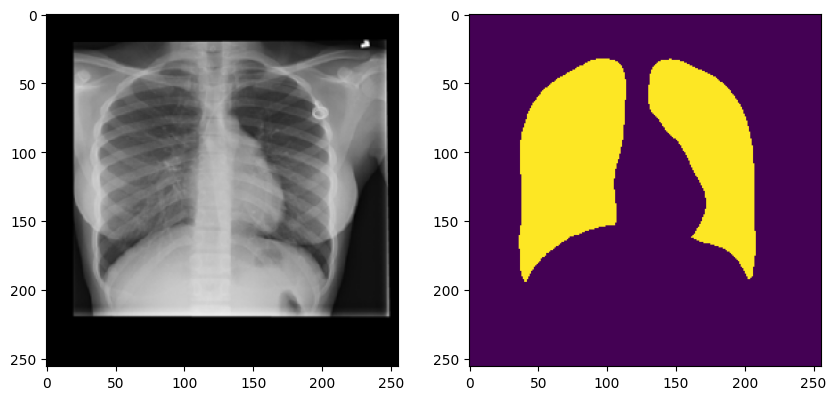

In [ ]:
image_0 = os.path.join(path_images, 'Normal-1.png')
mask_0 = os.path.join(path_masks, 'Normal-1.png')

fig, axs = plt.subplots(1, 2, figsize=(10, 6))

img = np.array(load_img(image_0, target_size=(256, 256), color_mode='rgb'))   # оригинал RGB с 3 каналами
mask = np.array(load_img(mask_0, target_size=(256, 256), color_mode='grayscale'))  # маска  в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)


### Создание списков

In [ ]:
input_img_path = sorted(
    [
        os.path.join(path_images, fname) for fname in os.listdir(path_images) if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(path_masks, fname) for fname in os.listdir(path_images) if fname.endswith(".png")
    ]
)

print(len(input_img_path), 'images')
print(len(target_img_path), 'masks')

10192 images
10192 masks


In [ ]:
print(input_img_path[0])
print(target_img_path[0])

/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-8846.png
/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-8846.png


### Генератор выборки

In [ ]:
num_classes = 2
img_size = (256, 256)
batch_size = 16

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path=None, num_classes=None, validation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation
        # определяем кол-во классов, если не было указано
        if num_classes is None:
            mask = np.array(load_img(target_img_path[0], target_size=self.img_size, color_mode='grayscale'))
            self.num_classes = len(np.unique(mask))
        else:
            self.num_classes = num_classes

    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            mask = mask / 255  # переводим 255 в 1 (в маске черное/белое)

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.HorizontalFlip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение
            y[_] = to_categorical(mask, num_classes=self.num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y


In [ ]:
seed = 42
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
total_images = len(input_img_path)
val_percent = 0.15
val_samples = int(total_images*val_percent)

# Разбиваем датасет на обучающую и валидационную выборку
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

print(f'Всего изображений: {total_images}')
print(f'На валидационную выборку отведено: {val_percent*100}%')
print(f'Изображений в обучающей выборке: {len(train_input_img_path)}')
print(f'Изображений в валидационной выборке: {len(val_input_img_path)}')

Всего изображений: 10192
На валидационную выборку отведено: 15.0%
Изображений в обучающей выборке: 8664
Изображений в валидационной выборке: 1528


In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

In [ ]:
num_classes = train_gen.num_classes
print(num_classes)

2


## Работа с моделью

Требуется построить следующую модель:

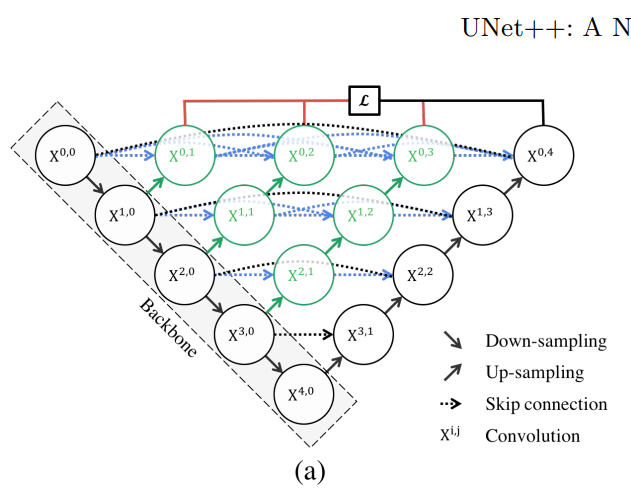

### Структура

In [ ]:
from keras import models, layers

def conv_block(x, filters, kernel_size=(3, 3), padding='same'):
    """Стандартный сверточный блок с активацией ReLU"""
    x = layers.Conv2D(filters, kernel_size=kernel_size, padding=padding)(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    """Энкодерный блок для понижения разрешения и увеличения признаков"""
    x = conv_block(x, filters)  # Блок свертки с фильтрами
    x = conv_block(x, filters)  # Блок свертки с фильтрами
    p = layers.MaxPooling2D(pool_size=(2, 2))(x)  # Пулинг для понижения разрешения
    return x, p

def decoder_block(x, skip, filters):
    """Декодерный блок для восстановления разрешения с пропуском"""
    x = layers.Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(x)  # Транспонированная свертка для увеличения разрешения
    x = layers.concatenate([x, skip])  # Конкатенация с пропуском из энкодера
    x = conv_block(x, filters)  # Блок свертки
    x = conv_block(x, filters)  # Блок свертки
    return x

def unet_plus_plus(input_shape=(256, 256, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Энкодер
    enc_00, pool_00 = encoder_block(inputs, 64)     # x(0,0)
    enc_10, pool_10 = encoder_block(pool_00, 128)   # x(1,0)
    enc_20, pool_20 = encoder_block(pool_10, 256)   # x(2,0)
    enc_30, pool_30 = encoder_block(pool_20, 512)   # x(3,0)
    enc_40, pool_40 = encoder_block(pool_30, 1024)  # x(4,0)

    # Промежуточные блоки
    dec_21 = decoder_block(enc_30, enc_20, 256)     # x(2,1)
    dec_11 = decoder_block(enc_20, enc_10, 128)     # x(1,1)
    dec_01 = decoder_block(enc_10, enc_00, 64)      # x(0,1)

    concat_skip_to_12 = layers.concatenate([enc_10, dec_11]) # скипы к блоку x(1,2)
    dec_12 = decoder_block(dec_21, concat_skip_to_12, 128) # x(1,2)

    concat_skip_to_02 = layers.concatenate([enc_00, dec_01]) # скипы к блоку x(0,2)
    dec_02 = decoder_block(dec_11, concat_skip_to_02, 64) # x(0,2)

    concat_skip_to_03 = layers.concatenate([enc_00, dec_01, dec_02]) # скипы к блоку x(0,3)
    dec_03 = decoder_block(dec_12, concat_skip_to_03, 64) # x(0,3)

    # Декодер
    dec_31 = decoder_block(enc_40, enc_30, 512)     # x(3,1)

    concat_skip_to_22 = layers.concatenate([enc_20, dec_21]) # скипы к блоку x(2,2)
    dec_22 = decoder_block(dec_31, concat_skip_to_22, 256)  # x(2,2)

    concat_skip_to_13 = layers.concatenate([enc_10, dec_11, dec_12])  # скипы к блоку x(1,3)
    dec_13 = decoder_block(dec_22, concat_skip_to_13, 128)  # x(1,3)

    concat_skip_to_04 = layers.concatenate([enc_00, dec_01, dec_02, dec_03])
    dec_04 = decoder_block(dec_13, concat_skip_to_04, 64)   # x(0,4)

    # Выходной слой
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(dec_04)

    model = models.Model(inputs, outputs)
    return model



In [ ]:
# Создание модели
model = unet_plus_plus(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_30 (ReLU)           │ (None, 256, 256, 64)   │              0 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 256, 256, 64)   │              0 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 64)   │              0 │ re_lu_31[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 128, 128, 128)  │              0 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ re_lu_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 128, 128, 128)  │              0 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 128)    │              0 │ re_lu_33[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 64, 64, 256)    │              0 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ re_lu_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 64, 64, 256)    │              0 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 256)    │              0 │ re_lu_35[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)      

 Total params: 36,158,018 (137.93 MB)

 Trainable params: 36,158,018 (137.93 MB)

 Non-trainable params: 0 (0.00 B)

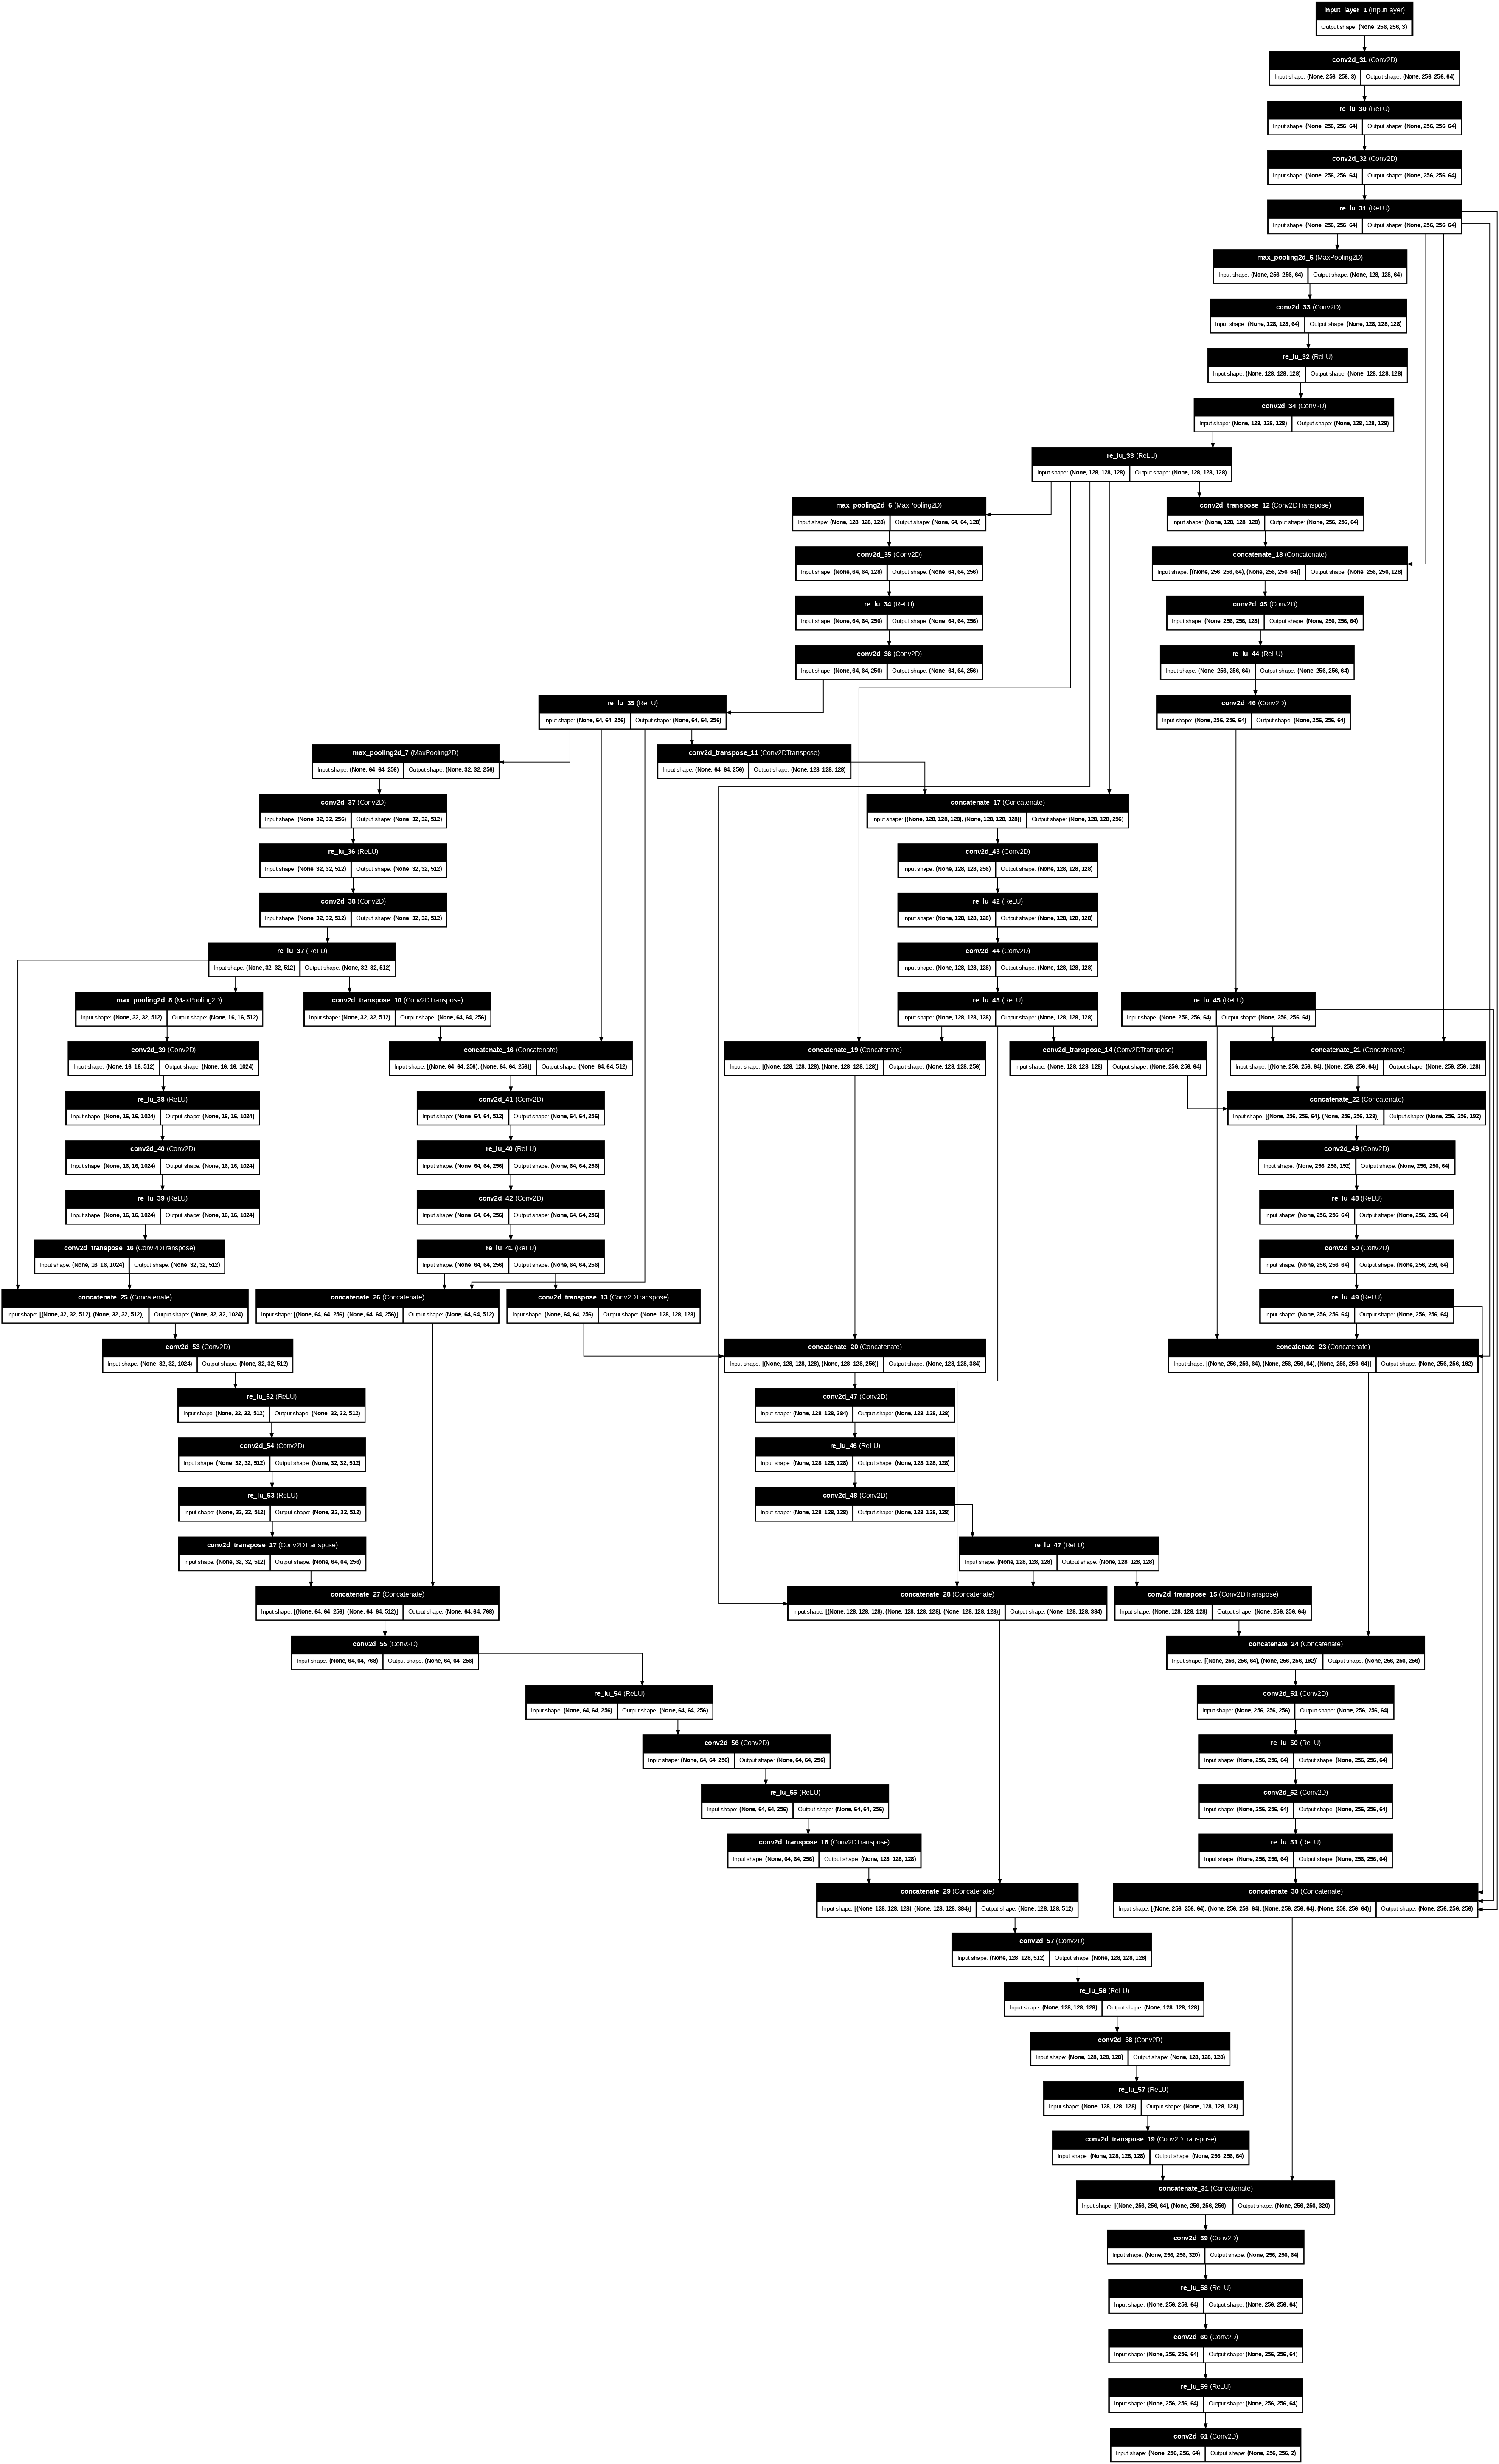

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Обучение

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]


In [ ]:
epochs = 1
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


541/541 ━━━━━━━━━━━━━━━━━━━━ 1120s 2s/step - accuracy: 0.8424 - loss: 0.3388 - val_accuracy: 0.9757 - val_loss: 0.0677


In [ ]:
model.save_weights('segmentation.weights.h5')

In [ ]:
result = model.evaluate(val_gen)

95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 532ms/step - accuracy: 0.9752 - loss: 0.0693


## Визуализация предсказания

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[0])            # отображаем картинку
        plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


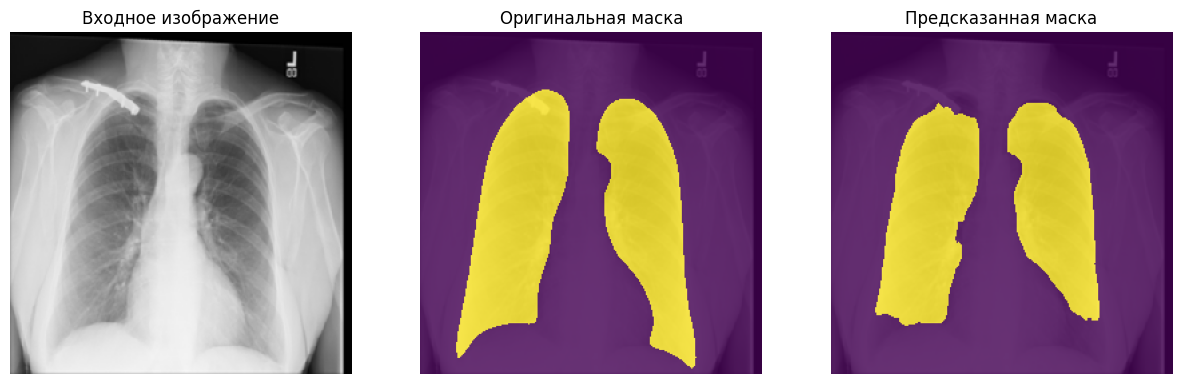

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


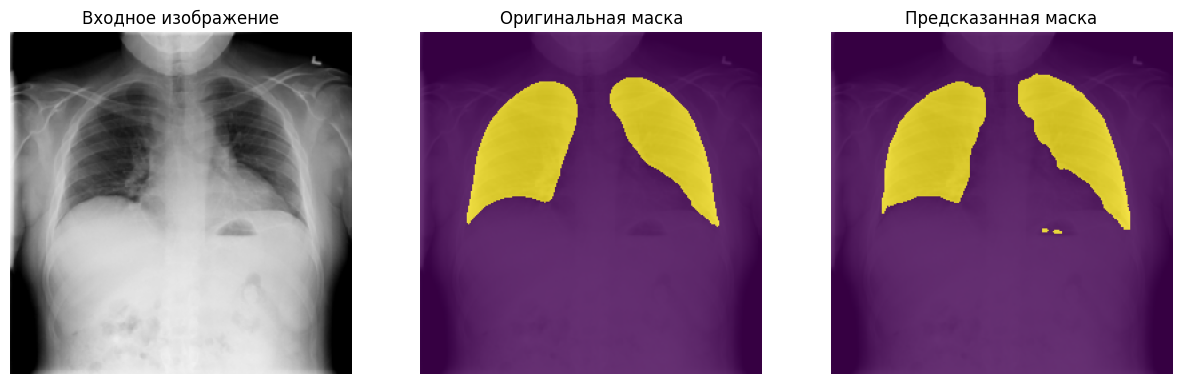

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


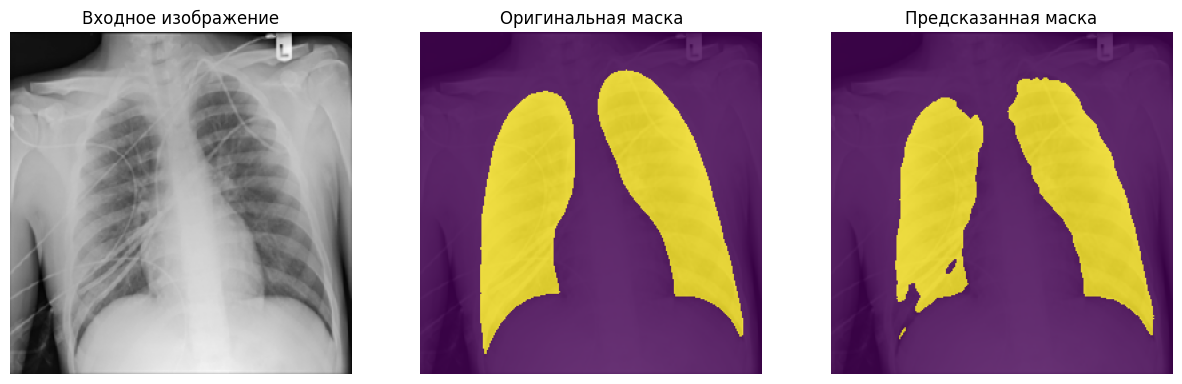

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


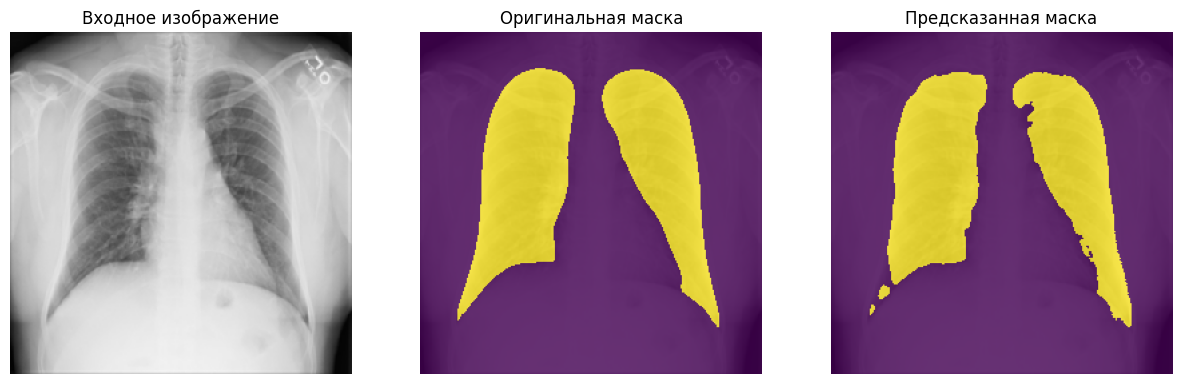

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


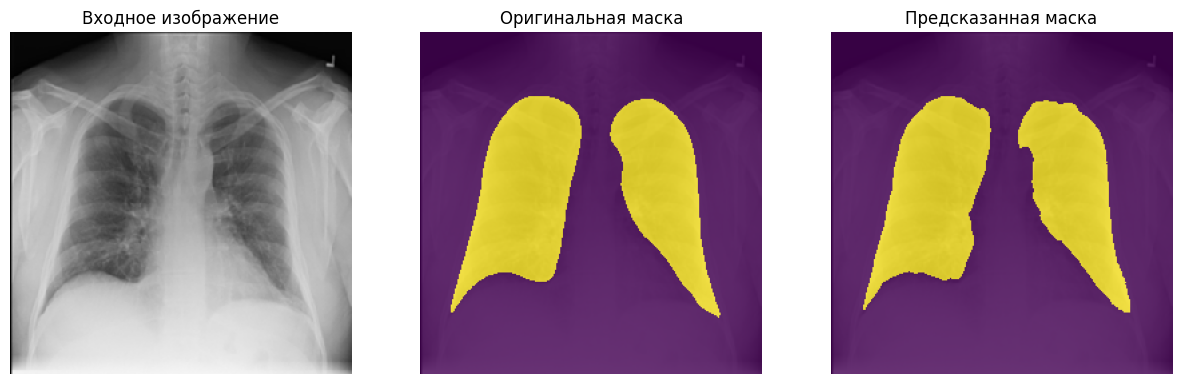

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


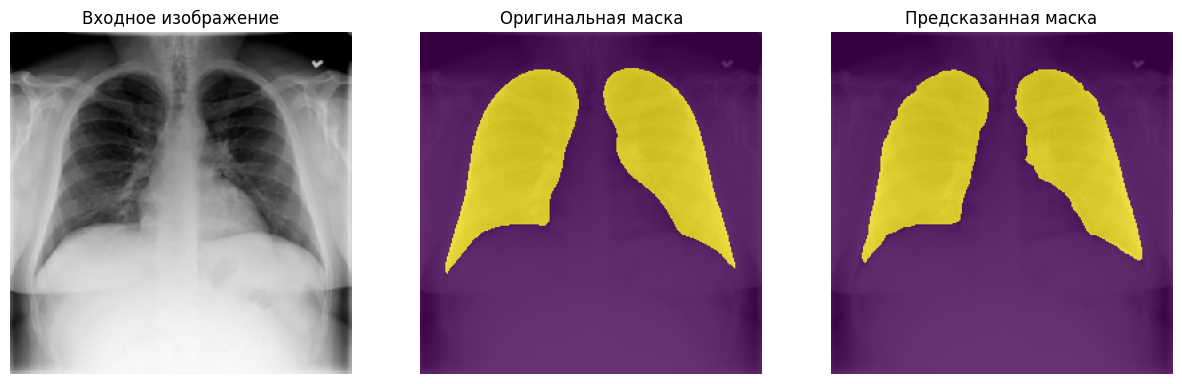

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


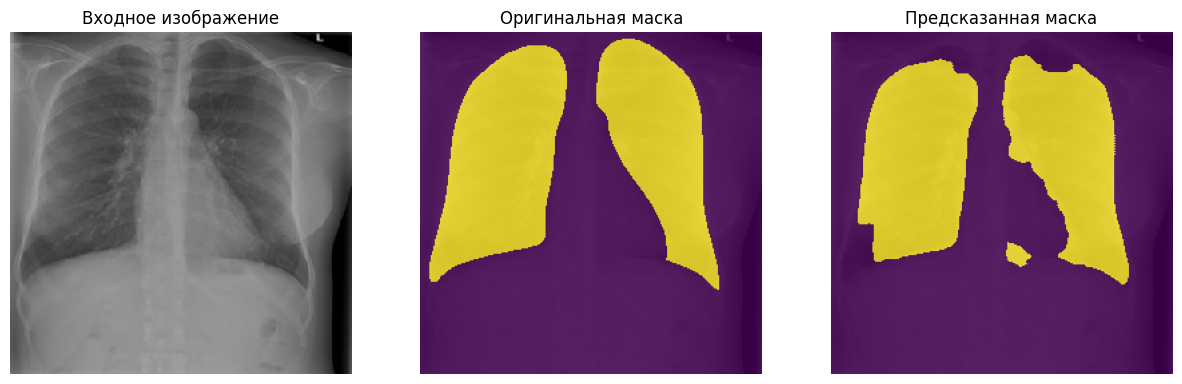

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


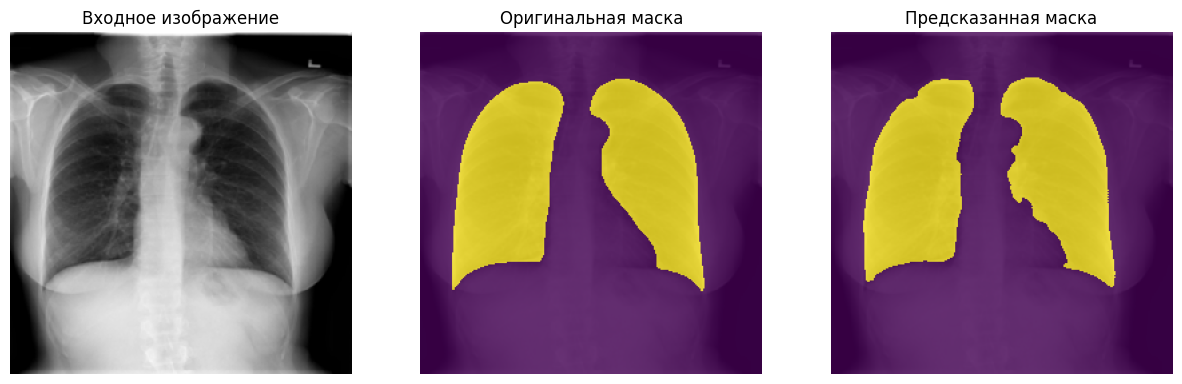

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


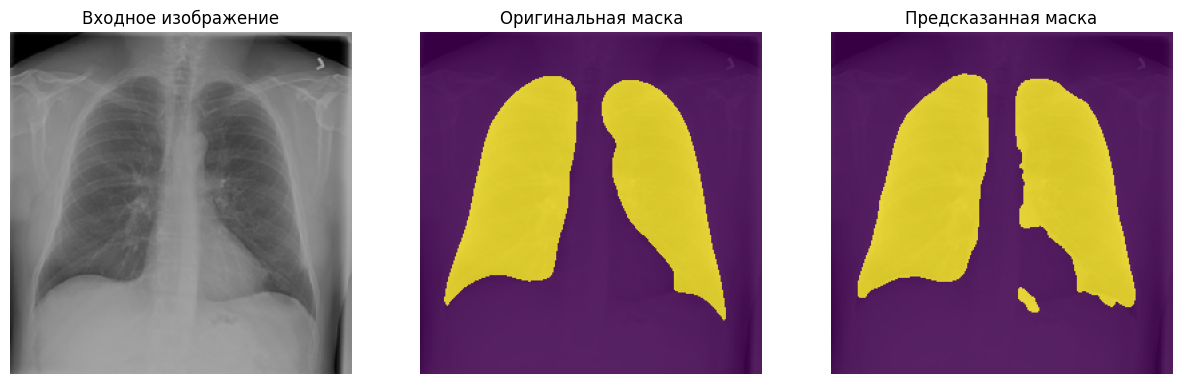

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


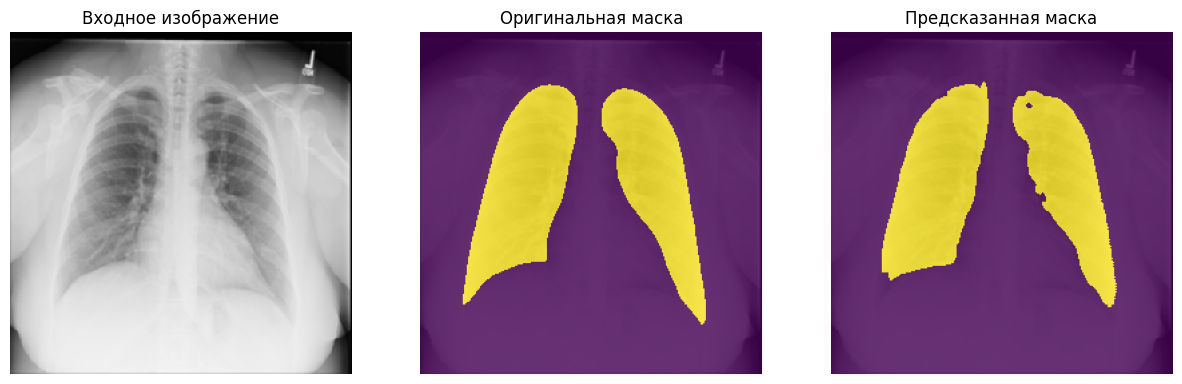

In [ ]:
for index in range(100,110):
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную

Отличный результат для всего одной эпохи обучения